# Modeling

There are three steps to creating this model:

1. **Vectorization**
2. **Train/Validation/Test Split**
3. **Modeling**: We apply a baseline CNN, FastText, and LSTM models.

In [1]:
import numpy as np
import re
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Conv1D, LSTM, GlobalMaxPooling1D, InputLayer, Dropout, SpatialDropout1D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import custom functions
from explore import *
from evaluation import *

In [2]:
# Import the dataset
df = pd.read_csv('processed_data/clean_data.csv')
df = df.dropna()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweets with no Stopwords'], 
                                                    df['Years'], test_size = 0.3, random_state = 2)

In [4]:
token = Tokenizer(num_words = 5000, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', lower = True, 
                  split = ' ', oov_token = True)
token.fit_on_texts(X_train)
X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

In [5]:
# One hot encoding for labels
encoder = LabelBinarizer()
encoder.fit(y_train)
transformed = encoder.transform(y_train)
y_train_encoded = pd.DataFrame(transformed)
transformed_test = encoder.transform(y_test)
y_test_encoded = pd.DataFrame(transformed_test)

In [6]:
max_length = max_seq_length(X_train_seq)
# Total number of words in the corpus
vocabulary_size = len(token.word_index)
number_of_words = 5000

In [7]:
X_train_seq_pad = pad_sequences(X_train_seq, maxlen = max_length, padding = 'post')
X_test_seq_pad = pad_sequences(X_test_seq, maxlen = max_length, padding = 'post')

In [8]:
X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(X_train_seq_pad, y_train_encoded, 
                                                                  test_size = 0.3, random_state = 3)

# CNN for Text Analysis

Neural networks analyze texts in a slightly different way with words as opposed to the sparse TF-IDF framework. Since this is a large dataset, a CNN maybe able to pick up intricate patterns. Preprocessing with CNNs requires it to be processed with Keras' `Embedding.()` when it comes to the modeling.

In [9]:
def define_CNN_model():
    cnn_model = models.Sequential()
    cnn_model.add(layers.Embedding(number_of_words, 200, input_length = max_length))
    cnn_model.add(layers.Conv1D(50, 3, activation = 'relu', input_shape = (200, 1)))
    cnn_model.add(layers.GlobalMaxPooling1D())
    cnn_model.add(layers.Dense(3, activation = 'softmax'))
    cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                      metrics = ['accuracy', f1, precision_measure, recall_measure])
    return cnn_model

In [10]:
cnn_model = define_CNN_model()
cnn_model.summary()
cnn_model_history = cnn_model.fit(X_train_emb, y_train_emb, epochs = 10, batch_size = 64, 
                                  validation_data = (X_val_emb, y_val_emb), verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 83, 200)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 81, 50)            30050     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 1,030,203
Trainable params: 1,030,203
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7973/7973 [==============================] - 337s 42ms/step - loss: 0.4658 - accuracy: 0.8363 - f1: 0.8287 - precision_measure: 0.8323 - recall_measure: 0.8264 - val_loss: 0.4235 - val_accuracy: 0.8465 - val_f1: 0.8462 - val_precisio

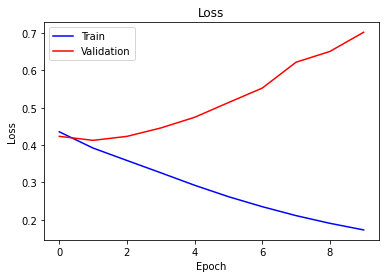

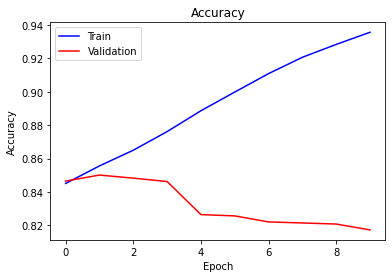

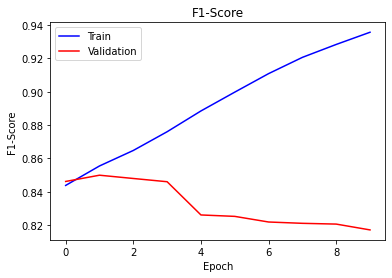

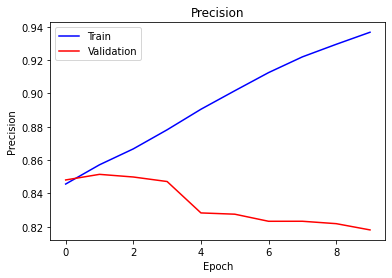

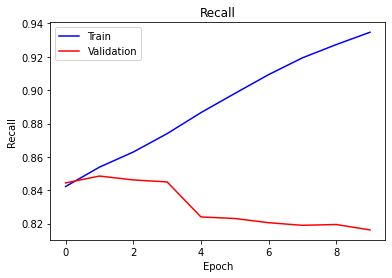

In [11]:
plot_history(cnn_model_history)

In [12]:
# Get classification report
y_pred = cnn_model.predict(X_test_seq_pad, batch_size = 64, verbose = 1)
y_pred_bool = encoder.inverse_transform(y_pred) # Undo one-hot encoding
print(classification_report(y_test, y_pred_bool))

4882/4882 [==============================] - 37s 8ms/step
              precision    recall  f1-score   support

        2017       0.87      0.90      0.89     85882
        2018       0.84      0.87      0.86    191654
        2019       0.43      0.31      0.36     34874

    accuracy                           0.82    312410
   macro avg       0.72      0.69      0.70    312410
weighted avg       0.80      0.82      0.81    312410



# FastText

In [13]:
def make_fast_text():
    fast_text = Sequential()
    fast_text.add(InputLayer((max_length,)))
    fast_text.add(Embedding(input_dim = vocabulary_size + 1, output_dim = 3, trainable = True))
    fast_text.add(SpatialDropout1D(0.5))
    fast_text.add(GlobalMaxPooling1D())
    fast_text.add(Dropout(0.5))
    fast_text.add(Dense(3, activation = 'softmax'))
    fast_text.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                      metrics = ['accuracy', f1, precision_measure, recall_measure])
    return fast_text

In [14]:
fast_text = make_fast_text()
fast_text.summary()
fast_text_history = fast_text.fit(X_train_emb, y_train_emb, epochs = 10, batch_size = 64, 
                                  validation_data = (X_val_emb, y_val_emb), verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 83, 3)             1123671   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 83, 3)             0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 3)                 0         
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
Total params: 1,123,683
Trainable params: 1,123,683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7973/7973 [==============================] - 143s 18ms/step - loss: 0.8674 - accuracy: 0.6552 - f1:

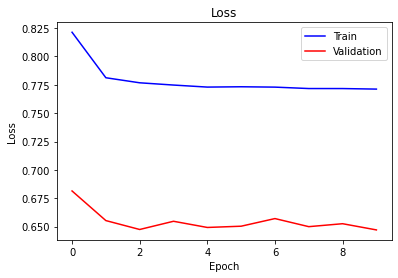

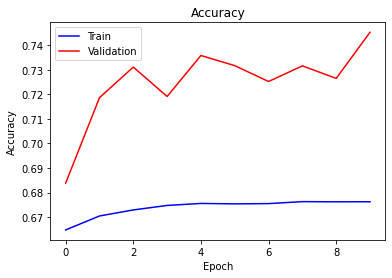

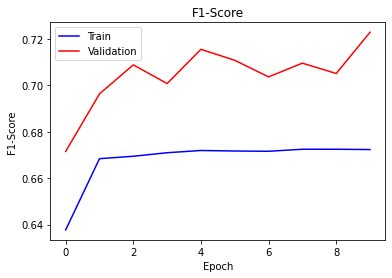

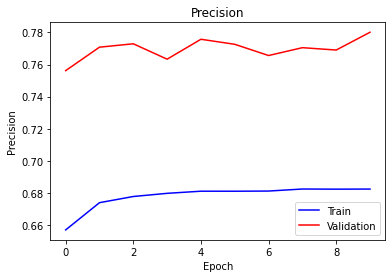

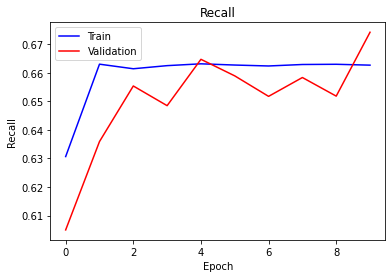

In [15]:
plot_history(fast_text_history)

In [16]:
# Get classification report
y_pred = fast_text.predict(X_test_seq_pad, batch_size = 64, verbose = 1)
y_pred_bool = encoder.inverse_transform(y_pred) # Undo one-hot encoding
print(classification_report(y_test, y_pred_bool))

4882/4882 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

        2017       0.87      0.56      0.68     85882
        2018       0.72      0.96      0.82    191654
        2019       0.00      0.00      0.00     34874

    accuracy                           0.75    312410
   macro avg       0.53      0.51      0.50    312410
weighted avg       0.68      0.75      0.69    312410



# LSTM 

In [17]:
def define_LSTM_model():
    lstm_model = Sequential()
    lstm_model.add(InputLayer((max_length,)))
    lstm_model.add(Embedding(input_dim = vocabulary_size + 1, output_dim = 3, trainable = True))
    lstm_model.add(LSTM(125))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(3, activation = 'softmax'))
    lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                       metrics = ['accuracy', f1, precision_measure, recall_measure])
    return lstm_model

In [18]:
lstm_model = define_LSTM_model()
lstm_model.summary()
lstm_model_history = lstm_model.fit(X_train_emb, y_train_emb, epochs = 10, batch_size = 64,
                                    validation_data = (X_val_emb, y_val_emb), verbose = 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 83, 3)             1123671   
_________________________________________________________________
lstm (LSTM)                  (None, 125)               64500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 378       
Total params: 1,188,549
Trainable params: 1,188,549
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7973/7973 [==============================] - 1045s 131ms/step - loss: 0.9042 - accuracy: 0.6132 - f1: 0.6073 - precision_measure: 0.6080 - recall_measure: 0.6067 - val_loss: 0.9005 - val_accuracy: 0.6139 - val_f1: 0.6139 - val_prec

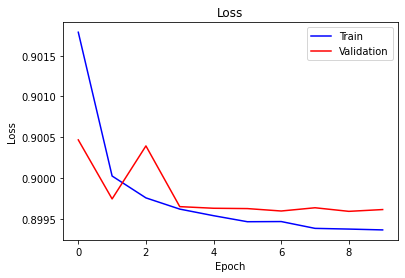

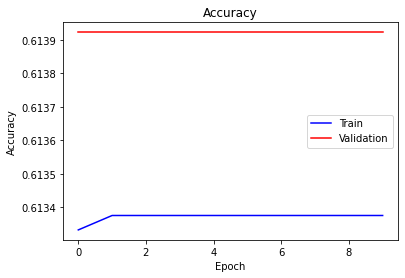

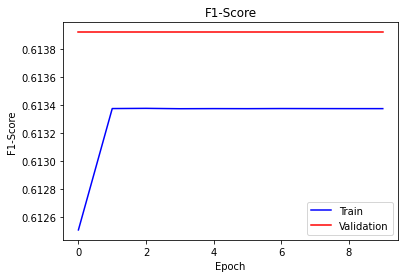

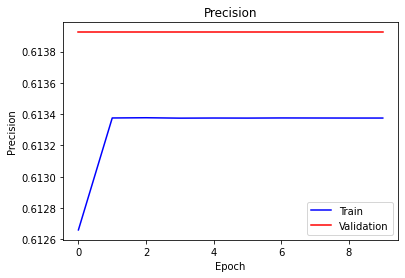

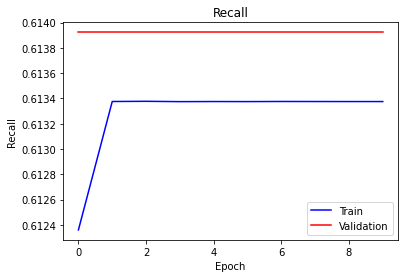

In [19]:
plot_history(lstm_model_history)

In [20]:
# Get classification report
y_pred = lstm_model.predict(X_test_seq_pad, batch_size = 64, verbose = 1)
y_pred_bool = encoder.inverse_transform(y_pred) # Undo one-hot encoding
print(classification_report(y_test, y_pred_bool))

4882/4882 [==============================] - 173s 35ms/step
              precision    recall  f1-score   support

        2017       0.00      0.00      0.00     85882
        2018       0.61      1.00      0.76    191654
        2019       0.00      0.00      0.00     34874

    accuracy                           0.61    312410
   macro avg       0.20      0.33      0.25    312410
weighted avg       0.38      0.61      0.47    312410

